<a href="https://colab.research.google.com/github/ivoytov/ilyaSpace/blob/master/NYC_price_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Housing Price Index for Manhattan/Brooklyn from Transaction Data

## Setup and Prepare the dataframe

In this section we import the data and clean it up. If you trust that we've one everything correctly, feel free to skip to the next section, where we use the historical transaction data to construct the first housing price index.

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import sparse

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
sns.set_theme()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
cols = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESideNTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE']
cols = [col.lower().replace(" ","_") for col in cols]

Download all real estate transaction data from [NYC.gov](https://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page) for January 2003 to July 2020. Only closed transactions are included. Column names are the same in all files. 

In [3]:
# ex: https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2019/2019_manhattan.xlsx
url_prefix = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales'
years = range(2010,2020)
links = [f"{url_prefix}/annualized-sales/{year}/{year}_manhattan.xls{'x' if year > 2017 else ''}" for year in years ]
links += [url_prefix + "/rollingsales_manhattan.xlsx", url_prefix + "/annualized-sales/2009_manhattan.xls",
         "https://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_manhattan.xls", 
         "https://www1.nyc.gov/assets/finance/downloads/excel/rolling_sales/sales_2007_manhattan.xls",
         *[f"https://www1.nyc.gov/assets/finance/downloads/sales_manhattan_0{n}.xls" for n in range(3,7)] ]
links += [f"{url_prefix}/annualized-sales/{year}/{year}_brooklyn.xls{'x' if year > 2017 else ''}" for year in years ]
links += [url_prefix + "/rollingsales_brooklyn.xlsx", url_prefix + "/annualized-sales/2009_brooklyn.xls",
         "https://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_brooklyn.xls", 
         "https://www1.nyc.gov/assets/finance/downloads/excel/rolling_sales/sales_2007_brooklyn.xls",
         *[f"https://www1.nyc.gov/assets/finance/downloads/sales_brooklyn_0{n}.xls" for n in range(3,7)] ]


Exclude any transaction with sale price under \$100,000 as it might not be an arms length transaction or just bad data. The very last file we downloaded covers period of the last twelve months, so we need to remove duplicates in the overlapping period from the prior year.

Filter transactions to only include following categories:
* Coops
  * `09  coops - walkup apartments`
  * `10  coops - elevator apartments`
  * `17  condo coops`
* Condos
  * `12  condos - walkup apartments`
  * `13  condos - elevator apartments`

In [4]:
df = pd.DataFrame()
for link in links:
    df = df.append(pd.read_excel(link, skiprows=4, names=cols, parse_dates=[20]), ignore_index=True)
    
df = df[['borough', 'neighborhood', 'building_class_category', 'block','lot', 'address', 'apartment_number', \
         'gross_square_feet', 'sale_price', 'year_built', 'sale_date']]
df.neighborhood = df.neighborhood.str.strip().str.title()
borough_type = CategoricalDtype(categories=['Manhattan', 'Brooklyn'], ordered=True)
df['borough'] = df.borough.map({1:"Manhattan", 3: "Brooklyn"}).astype(borough_type)

In [5]:
print("latest transaction in file:", df.sale_date.sort_values().iloc[-1])
COOP_CATEGORIES = "09|[^-]10|17" 
CONDO_CATEGORIES = "12|13"

coops = df.building_class_category.str.contains(COOP_CATEGORIES)
condos = df.building_class_category.str.contains(CONDO_CATEGORIES)

df['house_class'] = 'Condo'
df.loc[coops, 'house_class'] = 'Coop'

df = df[coops | condos]
df = df[(df.sale_price > 100000)].drop_duplicates()

latest transaction in file: 2021-06-30 00:00:00


We need to create a unique ID to track unique houses. For condos, that is the block/lot number combination. But all Coops in the same building share the exact same lot number, so it's not a unique ID. We extract the apartment number from the ending of the address.

In [6]:
df.loc[condos, "uid"] = df[condos].block.map(str) + '_' + df[condos].lot.map(str)
df.loc[coops, "uid"] = df[coops].block.map(str) + '_' + \
               df[coops].address.str.rsplit(',',n=1,expand=True)[1] \
                                .str.lower() \
                                .str.replace('(?:unit)?(?:apt)?[^a-z0-9\n]', '', regex=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


We convert transaction periods to quarters (our index will be quarterly as a result). If the same house sold multiple times in the same quarter, remove the first transaction(s) and only keep the last transaction. This most likely represents a contractor flip.

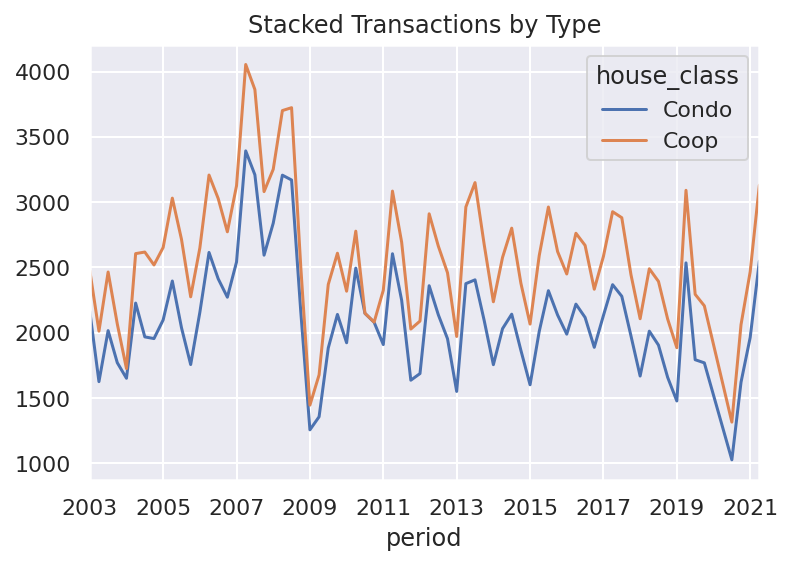

In [7]:
df['period'] = pd.PeriodIndex(df.sale_date, freq='Q')
df = df.drop_duplicates(subset=['period','uid'],keep='last')
df.groupby('period').house_class.value_counts().unstack().plot(kind='line', stacked=True,title="Stacked Transactions by Type")

In [8]:
qtr_offset = -1  # change this to -1 for latest quarter, -2 for the one before that and so on
mr_period = np.sort(df.period.unique())[qtr_offset]
print("Most recent period is", mr_period, "and # of transaction in this period:")
df[df.period == mr_period].house_class.value_counts()

Most recent period is 2021Q2 and # of transaction in this period:


Condo    2548
Coop      582
Name: house_class, dtype: int64

In [9]:
''' Function takes in DataFrame rpt_sales with columns `uid`, `period`, and `sale_price`. 
    Returns:
        design matrices X, W, and Z as specified in the Case Shiller index methodology
        array deltaT:    number of periods elapsed between each sale pair
        array uid_key:   for each row of matrices, which house it represents
        array periods:   list of all unique periods, so columns can be converted to Periods 
'''
def createDesignMatrices(rpt_sales):
    grouped = rpt_sales.groupby('uid')
    S = np.sum(grouped.size()-1)
    periods = list(rpt_sales.period.unique())
    T = len(periods)

    # construct blank design matrices
    X = np.zeros((S, T))
    deltaT = np.zeros((S,1))
    
    uid_key = []
    row = 0
    for house, group in grouped:
      for i in range(len(group)-1):
        first = (group.iloc[i].sale_price, periods.index(group.iloc[i].period))
        second = (group.iloc[i+1].sale_price, periods.index(group.iloc[i+1].period))

        X[row,first[1]] = -first[0]
        X[row,second[1]] = second[0]
        deltaT[row] = second[1] - first[1]

        uid_key.append(house)
        row += 1

    W = np.reshape(-X[:,0],(-1,1))
    X = X[:,1:]
    Z = np.sign(X)

    return sparse.csr_matrix(X), W, sparse.csr_matrix(Z), deltaT, uid_key, periods

'''
    Constructs Case Shiller repeat sales index
    inputs: X,Z,W - design matrices as specified in the Case Shiller methodology. X and Z are sparse matrices
            periods - array of all periods in the sample
    outputs: DataFrame with index of periods and columns `weighted` and `unweighted` for the house price index
            first period index value is guaranteed to be 1.0 by convention
'''
def buildIndex(X, Z, W, deltaT, periods):
    #1) Estimate b by running regression using instrumental variables b = (Z'X)^-1 x X'w
    coeff = sparse.linalg.inv(Z.T * X) * Z.T * W
    #coeff = np.linalg.inv(Z.T.dot(X)).dot(Z.T).dot(W)
    idx = 1/(coeff.reshape(X.shape[1]))
    unweighted = pd.DataFrame([1,*idx], index=periods, columns=['unweighted'])

    #2) Calculate weights for each observation 
    resid = W - X.dot(coeff)
    reg = LinearRegression().fit(deltaT, resid**2)
    weights = np.sqrt(reg.predict(deltaT).clip(min=0.00001))
    Omega = sparse.diags(np.reshape(1/weights,X.shape[0]))

    #3) Estimate b again incorporating weights b = (Z'OmegaX)^-1 x Z'Omega w
    coeff_weighted = sparse.linalg.inv(Z.T * Omega * X) * Z.T * Omega * W
    idx_weighted = 1/(coeff_weighted.reshape(X.shape[1]))
    weighted = pd.DataFrame([1,*idx_weighted],index=periods, columns=['weighted'])

    return pd.concat([unweighted, weighted], axis=1), weights

'''
    Function generates unweighted, weighted, and smoothed (rolling) values for price index
    Takes in DataFrame and column key, an index will be returned for each unique value in df.key
'''
def generateIndexValues(df, key):
    grouped = df.groupby(key)
    results = None
    for name, group in grouped:
        X, W, Z, deltaT, uid_key, periods = createDesignMatrices(group)
        try:
            idx,weights = buildIndex(X,Z,W, deltaT, periods)
            idx[key] = name
            
            smoothed = idx.weighted.rolling(4,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).rename("smoothed")
            
            idx = pd.concat([idx,smoothed], axis=1)
            
            if results is None:
                results = idx
            else:
                results = pd.concat([results, idx])
            
        except Exception as e:
            print(name, e)
      
    return results

def plot_standings(data, title, figsize=(15,2.5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    bars = ax.bar(data.index, data, width=.825, capsize=2, color=[.7,.7,.7])

    ax.axhline(0.0, linestyle=':', color='k', lw=1)

    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1%}"))

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticklabels(data.index, rotation=90, fontsize=11)
    fig.set_facecolor('w')

''' Helper function to create a time series index plot. 
Result is a dataframe with cols weighted and smoothed'''
def plot_idx(result, ax, area_name, ylim=(0.5,3.0)):
    index = result.index.to_timestamp()
    ax.set_title(f"{area_name} House Price Index")

    ax.plot(index, result.weighted.values, 
                   c='k',
                   linestyle=':',
                   alpha=.5, label="Actual")

    ax.plot(index, result.smoothed.values, label="Smoothed")
    
    ax.axhline(1.0, c='k', lw=1, alpha=.25)
    ax.legend(frameon=False)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    
    ax.set_ylim(ylim[0],ylim[1])
    ax.margins(0)

## Calculate the index values for Manhattan/Brooklyn

Filter for only homes that have sold more than once (not technically required but reduces memory usage), sort by date

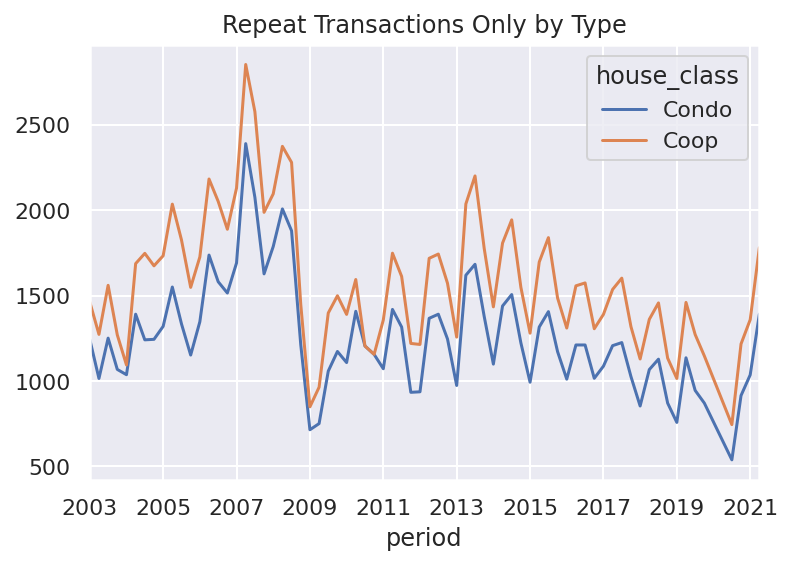

In [10]:
rpt_sales = df[['period', 'uid', 'sale_price', 'borough', 'neighborhood', 'sale_date', 'house_class']] \
                .groupby('uid') \
                .filter(lambda x: len(x) >= 2) \
                .sort_values('sale_date')

rpt_sales.groupby('period').house_class.value_counts().unstack().plot(kind='line', stacked=True,title="Repeat Transactions Only by Type")

Number of repeat transactions in the most recent period

In [11]:
rpt_sales[rpt_sales.period == mr_period].house_class.value_counts()

Condo    1392
Coop      389
Name: house_class, dtype: int64

Build design matrices, and construct the index values. Indices are constructed using the repeat sales methodology, meaning that we only look at homes that have sold several times and track the percentage change in price between the first sale and the next sale, which ideally represents an apples-to-apples comparison. See Case Shiller methodology for full description. Known issues is that if the house was remodeled or otherwise improved, we don't have this information so it wouldn't get incorporated. But homes also on average lose value to depreciation/age, and with thousands of transactions this represents the best price comparison possible.

In [12]:
X, W, Z, deltaT, uid_key, periods = createDesignMatrices(rpt_sales)
idx_all, weights = buildIndex(X, Z, W, deltaT, periods)

Plot the weighted house price index along with a 1-year/4-quarter rolling average.

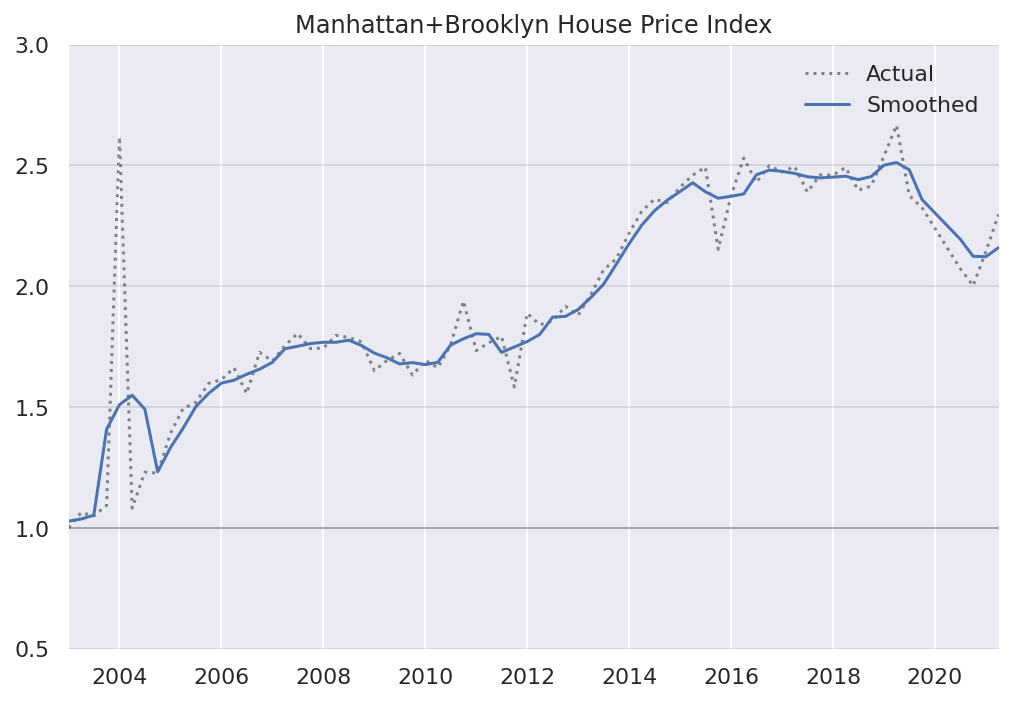

In [13]:
smoothed = idx_all.weighted.rolling(4,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).rename("smoothed")

fig, ax = plt.subplots(figsize=(600/72,400/72))
idx_all = pd.concat([idx_all, smoothed], axis=1)
plot_idx(idx_all, ax, "Manhattan+Brooklyn")

# Borough

Create a separate index for Manhattan and Brooklyn

In [14]:
borough_idx = generateIndexValues(rpt_sales,'borough')

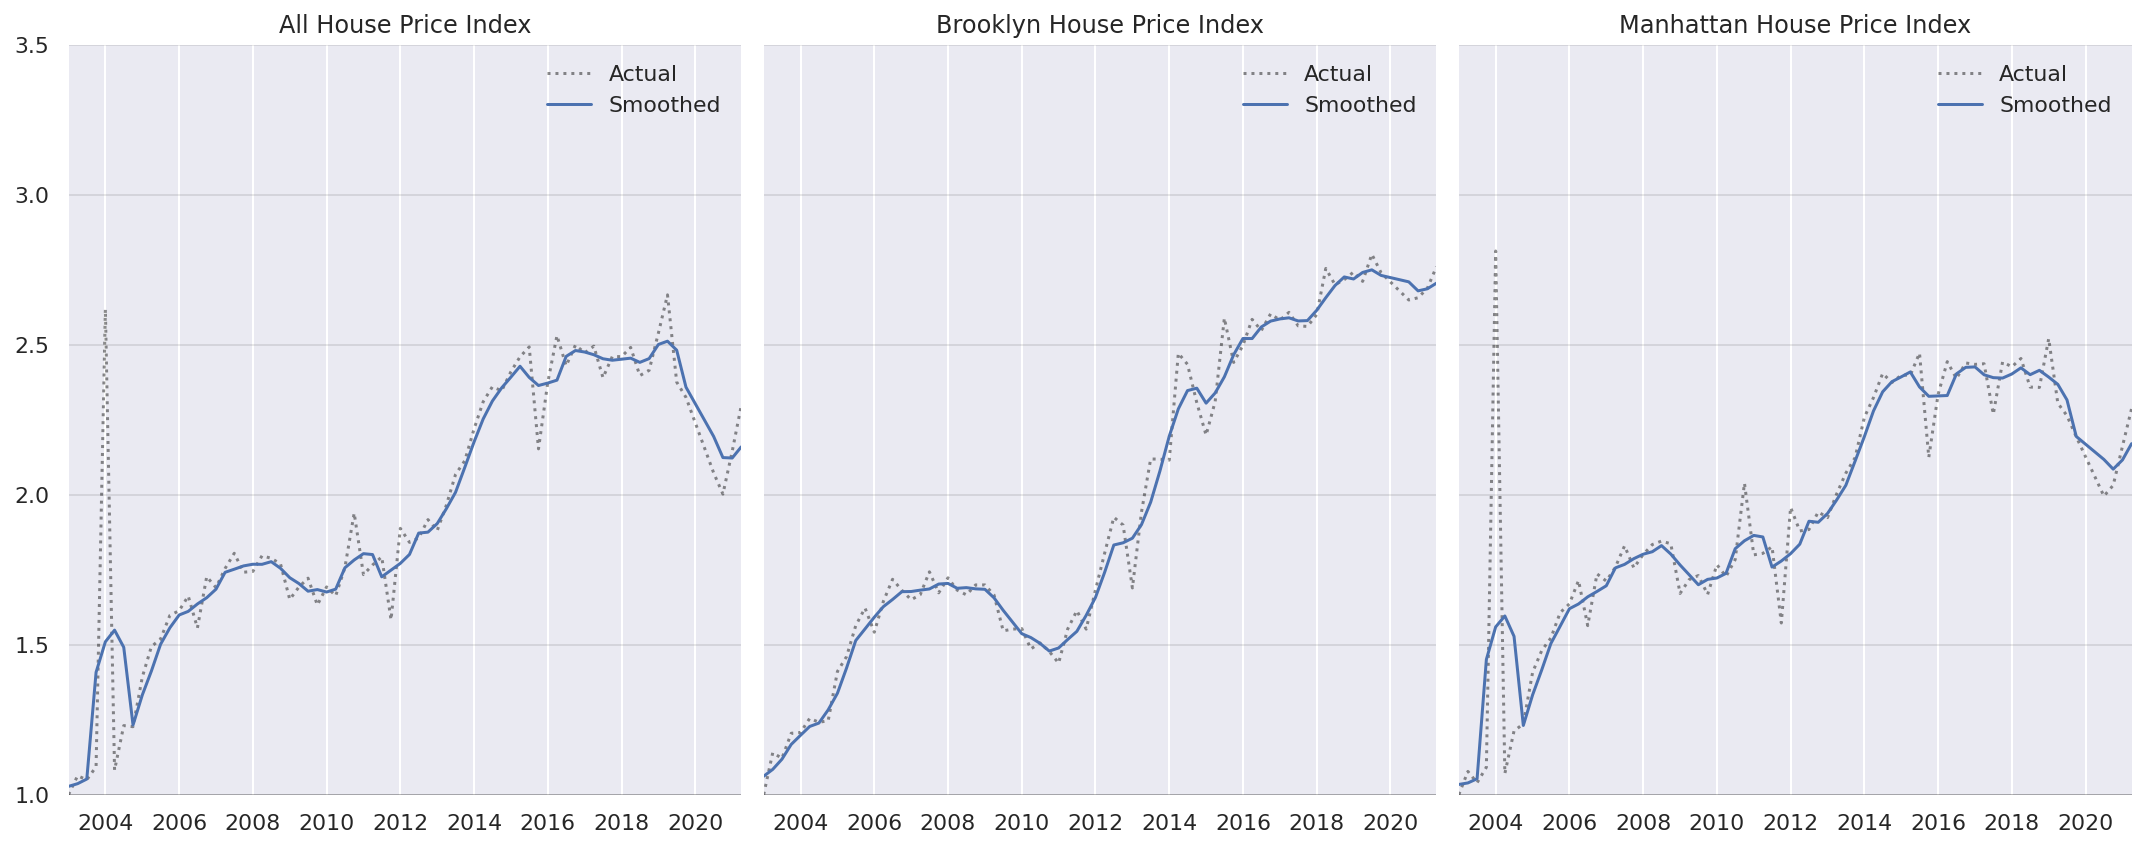

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)

plot_idx(idx_all, axes.flat[0], "All", ylim=(1,3.5))

for row, (name, idx) in enumerate(borough_idx.groupby('borough'),1):
    plot_idx(idx, axes.flat[row], name, ylim=(1,3.5))
                                  
fig.tight_layout()

borough
Brooklyn     -1%
Manhattan    -1%
All          -8%
Name: 2021Q2, dtype: object

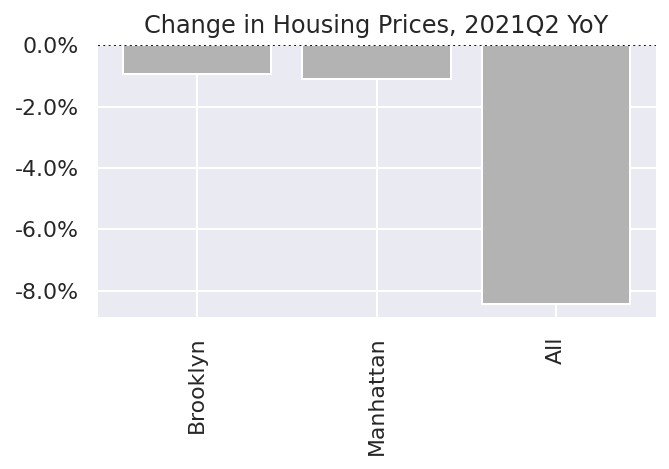

In [16]:
mr = borough_idx.set_index('borough',append=True).smoothed.unstack('borough').pct_change(4).iloc[qtr_offset]
mr.loc['All'] = idx_all.smoothed.pct_change(4).iloc[qtr_offset:].values[0]
plot_standings(mr, title=f"Change in Housing Prices, {idx_all.index[qtr_offset]} YoY", figsize=(5,2.5))
mr.map("{:,.0%}".format)

borough
Brooklyn     1%
Manhattan    3%
All          2%
Name: 2021Q2, dtype: object

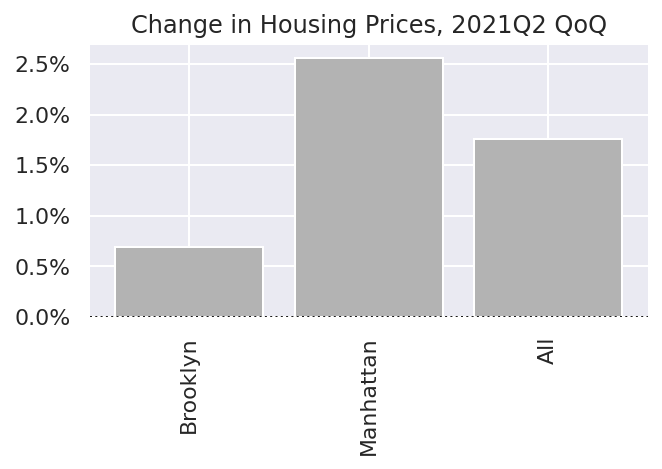

In [17]:
mr = borough_idx.set_index('borough',append=True).smoothed.unstack('borough').pct_change().iloc[qtr_offset]
mr.loc['All'] = idx_all.smoothed.pct_change().iloc[qtr_offset:].values[0]
plot_standings(mr, title=f"Change in Housing Prices, {idx_all.index[qtr_offset]} QoQ", figsize=(5,2.5))
mr.map("{:,.0%}".format)

## Calculate index values for Condos and Coops

We use the same methodology to generate separate indexes for Condos and Coops in Manhattan. As shown above, there are 4x more condo transactions than coop transactions in our dataset, so the condo index has higher statistical validity. 

In [18]:
house_class_idx = generateIndexValues(rpt_sales,'house_class')

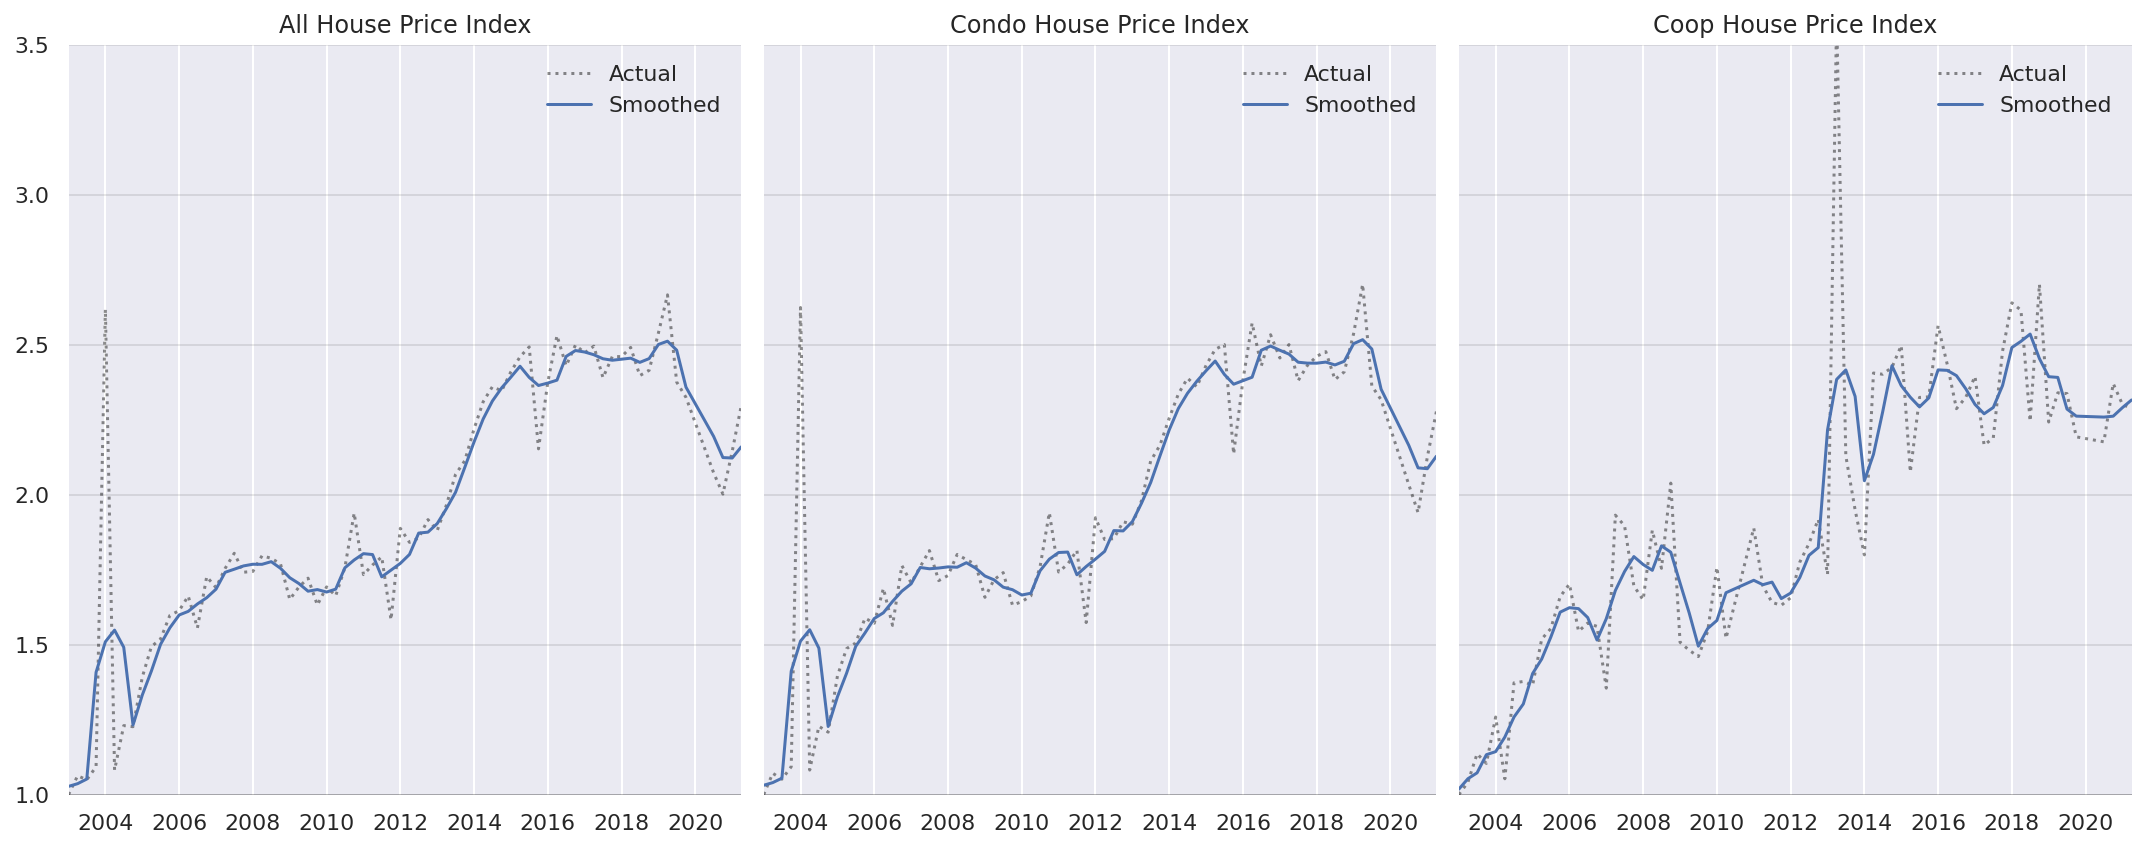

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)

plot_idx(idx_all, axes.flat[0], "All", ylim=(1,3.5))

for row, (name, idx) in enumerate(house_class_idx.groupby('house_class'),1):
    plot_idx(idx, axes.flat[row], name, ylim=(1,3.5))
                                  
fig.tight_layout()

Show the year over year change in prices:

house_class
Condo    -9%
Coop      2%
All      -8%
Name: 2021Q2, dtype: object

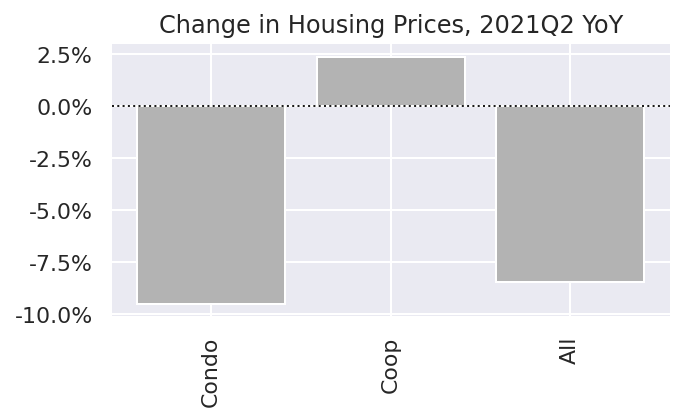

In [20]:
mr = house_class_idx.set_index('house_class',append=True).smoothed.unstack('house_class').pct_change(4).iloc[qtr_offset]
mr.loc['All'] = idx_all.smoothed.pct_change(4).iloc[qtr_offset:].values[0]
plot_standings(mr, title=f"Change in Housing Prices, {idx_all.index[qtr_offset]} YoY", figsize=(5,2.5))
mr.map("{:,.0%}".format)

Show the Quarter over Quarter change:

house_class
Condo    2%
Coop     1%
All      2%
Name: 2021Q2, dtype: object

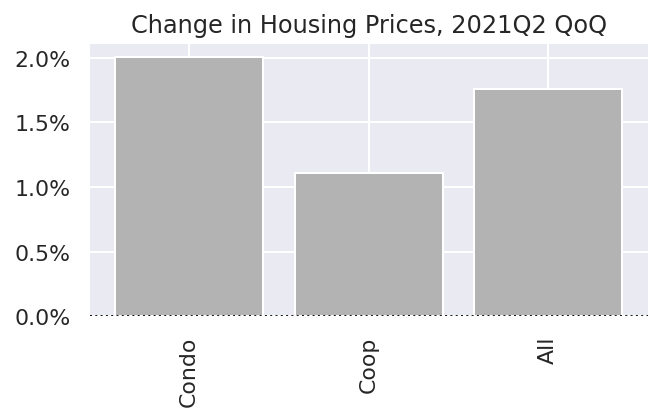

In [21]:
mr = house_class_idx.set_index('house_class',append=True).smoothed.unstack('house_class').pct_change().iloc[qtr_offset]
mr.loc['All'] = idx_all.smoothed.pct_change().iloc[qtr_offset:].values[0]
plot_standings(mr, title=f"Change in Housing Prices, {idx_all.index[qtr_offset]} QoQ", figsize=(5,2.5))
mr.map("{:,.0%}".format)

## Calculate index values for each neighborhood

Combine some of the smaller neighborhoods together and eliminate very tiny neighborhoods. 

Here are the reasons why certain neighborhoods were combined:
* All UES and UWS subdivions merged together as some were too few or generating volatile values
* Chinatown and Little Italy both had way too few data transactions on their own. Lower East Side was generating too volatile index values and is adjancent to both - merged together
* Javits Center (now known as "Hudson Yards") only had 119 datapoints in last 10 years. Midtown CBD has very few transactions as well. Fashion district and Gramercy were generating volatile index values. All three merged together as Midtown South.
* Southbridge and Civic Center are tiny neighborhoods below Tribeca with few transactions, merged with Financial District.
* Harlem, East, West and Upper had too few transactions and generated volatile values on their own, merged together
* Kips Bay was generating very volatile index values. Kips Bay merged with Flatiron (I debated merging with Murray Hill or Gramercy). 
* Manhattan Valley, Morningside, and Inwood merged together as too few values

Brooklyn has a LOT of different neighborhoods and much lower transaction volume per neighborhood. Many need to be removed or grouped to generate valid results.
* Marine Park, Bush Terminal, and Navy Yard have zero datapoints and must be excluded (otherwise model returns infinite values)
* Red Hook is a singular matrix due to very few listings, must be classified with others



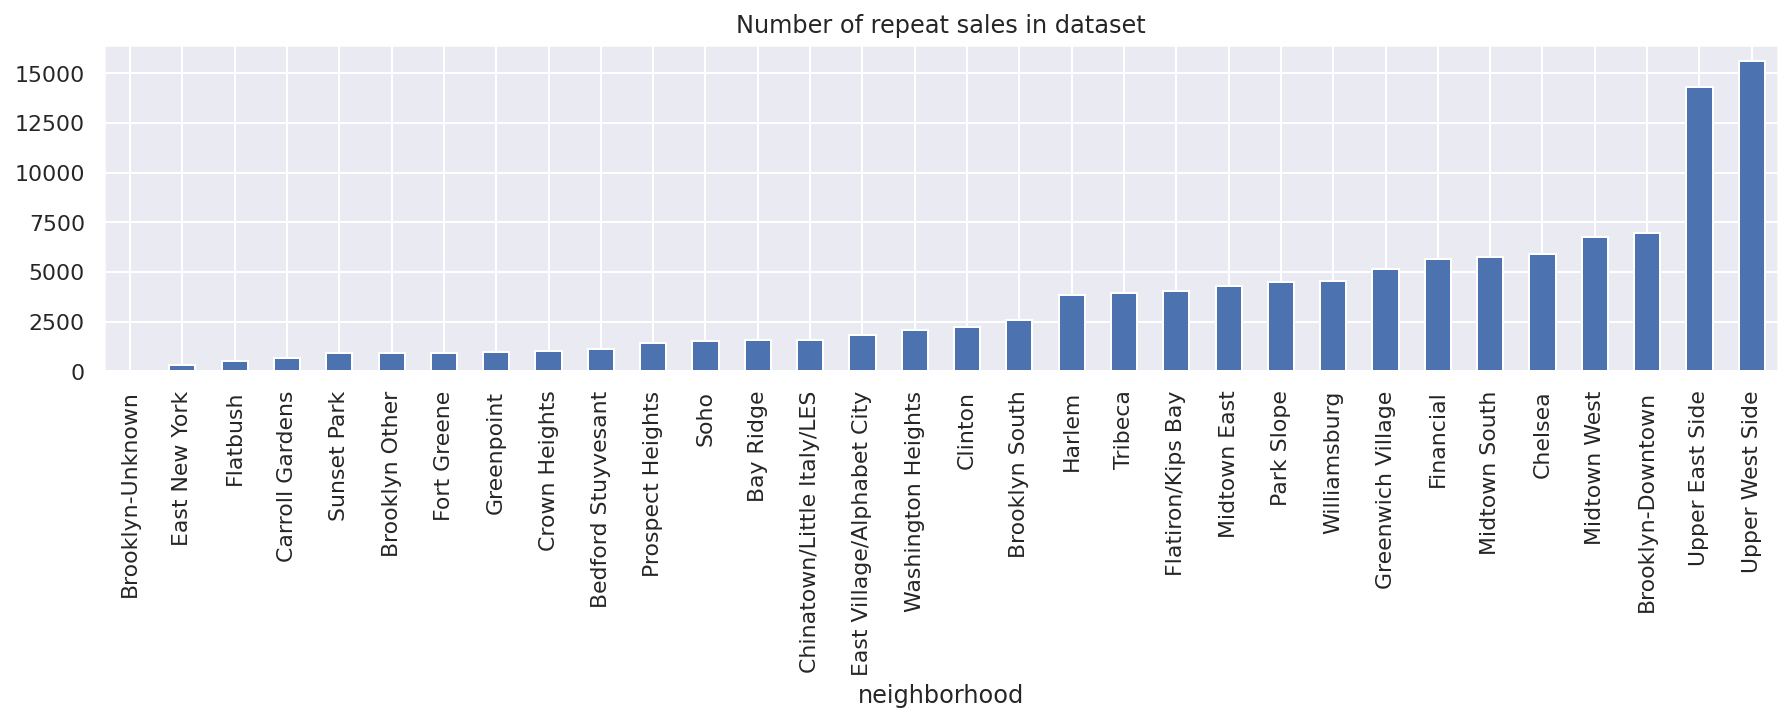

In [22]:
# exclude neighborhoods with very few datapoints
FILTERED_NEIGHBORHOODS=['Manhattan-Unknown',
                        'Roosevelt Island',
                        'Bush Terminal',
                        'Navy Yard',
                        ]
COMBINED_NEIGHBORHOODS = {
    'Chinatown':                 'Chinatown/Little Italy/LES',
    'Little Italy':              'Chinatown/Little Italy/LES',
    'Lower East Side':           'Chinatown/Little Italy/LES',
    'East Village':              'East Village/Alphabet City',
    'Alphabet City':             'East Village/Alphabet City',
    'Civic Center':              'Financial',
    'Southbridge':               'Financial',
    'Kips Bay':                  'Flatiron/Kips Bay',
    'Flatiron':                  'Flatiron/Kips Bay',
    'Greenwich Village-West':    'Greenwich Village',
    'Greenwich Village-Central': 'Greenwich Village',
    'Harlem-West':               'Harlem',
    'Harlem-Upper':              'Harlem',
    'Harlem-East':               'Harlem',
    'Harlem-Central':            'Harlem',
    'Javits Center':             'Midtown South',
    'Fashion':                   'Midtown South',
    'Midtown Cbd':               'Midtown South',
    'Gramercy':                  'Midtown South',
    'Murray Hill':               'Midtown South',
    'Upper East Side (96-110)':  'Upper East Side',
    'Upper East Side (79-96)':   'Upper East Side',
    'Upper East Side (59-79)':   'Upper East Side',
    'Upper West Side (59-79)':   'Upper West Side',
    'Upper West Side (79-96)':   'Upper West Side',
    'Upper West Side (96-116)':  'Upper West Side',
    'Manhattan Valley':          'Washington Heights',
    'Morningside Heights':       'Washington Heights',
    'Inwood':                    'Washington Heights',
    'Washington Heights Upper':  'Washington Heights',
    'Washington Heights Lower':  'Washington Heights',
    'Manhattan Beach':           'Brooklyn South',
    'Gowanus':                   'Brooklyn Other',
    'Marine Park':               'Brooklyn South',
    'Bush Terminal':             'Brooklyn Other',
    'Flatbush-Lefferts Garden':  'Flatbush',
    'Navy Yard':                 'Brooklyn Other',
    'Ocean Parkway-South':       'Brooklyn Other',
    'Ocean Parkway-North':       'Brooklyn Other',
    'Wyckoff Heights':           'Brooklyn Other',
    'Old Mill Basin':            'Brooklyn Other',
    'Ocean Hill':                'Brooklyn Other',
    'Bushwick':                  'Brooklyn Other',
    'Midwood':                   'Brooklyn Other',
    'Canarsie':                  'Brooklyn Other',
    'Bath Beach':                'Bay Ridge',
    'Bensonhurst':               'Bay Ridge',
    'Dyker Heights':             'Bay Ridge',
    'Borough Park':              'Bay Ridge',
    'Kensington':                'Brooklyn Other',
    'Coney Island':              'Brooklyn South',
    'Red Hook':                  'Brooklyn Other',
    'Manhattan Beach':           'Brooklyn South',
    'Sheepshead Bay':            'Brooklyn South',
    'Bergen Beach':              'Brooklyn South',
    'Madison':                   'Brooklyn South',
    'Gravesend':                 'Brooklyn South',
    'Marine Park':               'Brooklyn South',
    'Brighton Beach':            'Brooklyn South',
    'Flatbush-East':             'Flatbush',
    'Flatbush-Central':          'Flatbush',
    'Flatbush-North':            'Flatbush',
    'Flatbush-Lefferts Garden':  'Flatbush',
    'Williamsburg-Central':      'Williamsburg',
    'Williamsburg-East':         'Williamsburg',
    'Williamsburg-North':        'Williamsburg',
    'Williamsburg-South':        'Williamsburg',
    'Cobble Hill-West':          'Brooklyn-Downtown',
    'Park Slope South':          'Park Slope',
    'Windsor Terrace':           'Park Slope',
    'Downtown-Fulton Mall':      'Brooklyn-Downtown',
    'Downtown-Metrotech':        'Brooklyn-Downtown',
    'Downtown-Fulton Ferry':     'Brooklyn-Downtown',
    'Boerum Hill':               'Brooklyn-Downtown',
    'Clinton Hill':              'Brooklyn-Downtown',
    'Cobble Hill':               'Brooklyn-Downtown',
    'Brooklyn Heights':          'Brooklyn-Downtown',
    'Gowanus':                   'Brooklyn-Downtown',
}
filtered = rpt_sales.neighborhood.isin(FILTERED_NEIGHBORHOODS)
neighborhood_sales = rpt_sales[~filtered].replace({"neighborhood": COMBINED_NEIGHBORHOODS})
neighborhood_sales.groupby('neighborhood').size().sort_values().plot.bar(figsize=(15,3), title="Number of repeat sales in dataset")

Show the number of repeat transactions in each neighborhood for the most recent period.

In [23]:
neighborhood_sales[neighborhood_sales.period==mr_period].groupby('neighborhood').size().sort_values(ascending=False)

neighborhood
Upper East Side               217
Upper West Side               204
Brooklyn-Downtown             134
Chelsea                        90
Williamsburg                   89
Midtown South                  80
Tribeca                        77
Greenwich Village              75
Midtown West                   73
Park Slope                     68
Financial                      67
Flatiron/Kips Bay              66
Harlem                         59
Midtown East                   44
Brooklyn South                 41
Clinton                        40
Washington Heights             37
Bay Ridge                      34
Crown Heights                  32
Brooklyn Other                 28
East Village/Alphabet City     27
Prospect Heights               27
Soho                           26
Chinatown/Little Italy/LES     25
Greenpoint                     23
Bedford Stuyvesant             23
Sunset Park                    19
Flatbush                       13
Carroll Gardens                13
F

Create index values for every neighborhood, along with rolling averages

In [24]:
neighborhood_idx = generateIndexValues(neighborhood_sales,'neighborhood')

Brooklyn-Unknown need at least one array to concatenate


Display graph indices for all neighborhoods, in alphabetical order

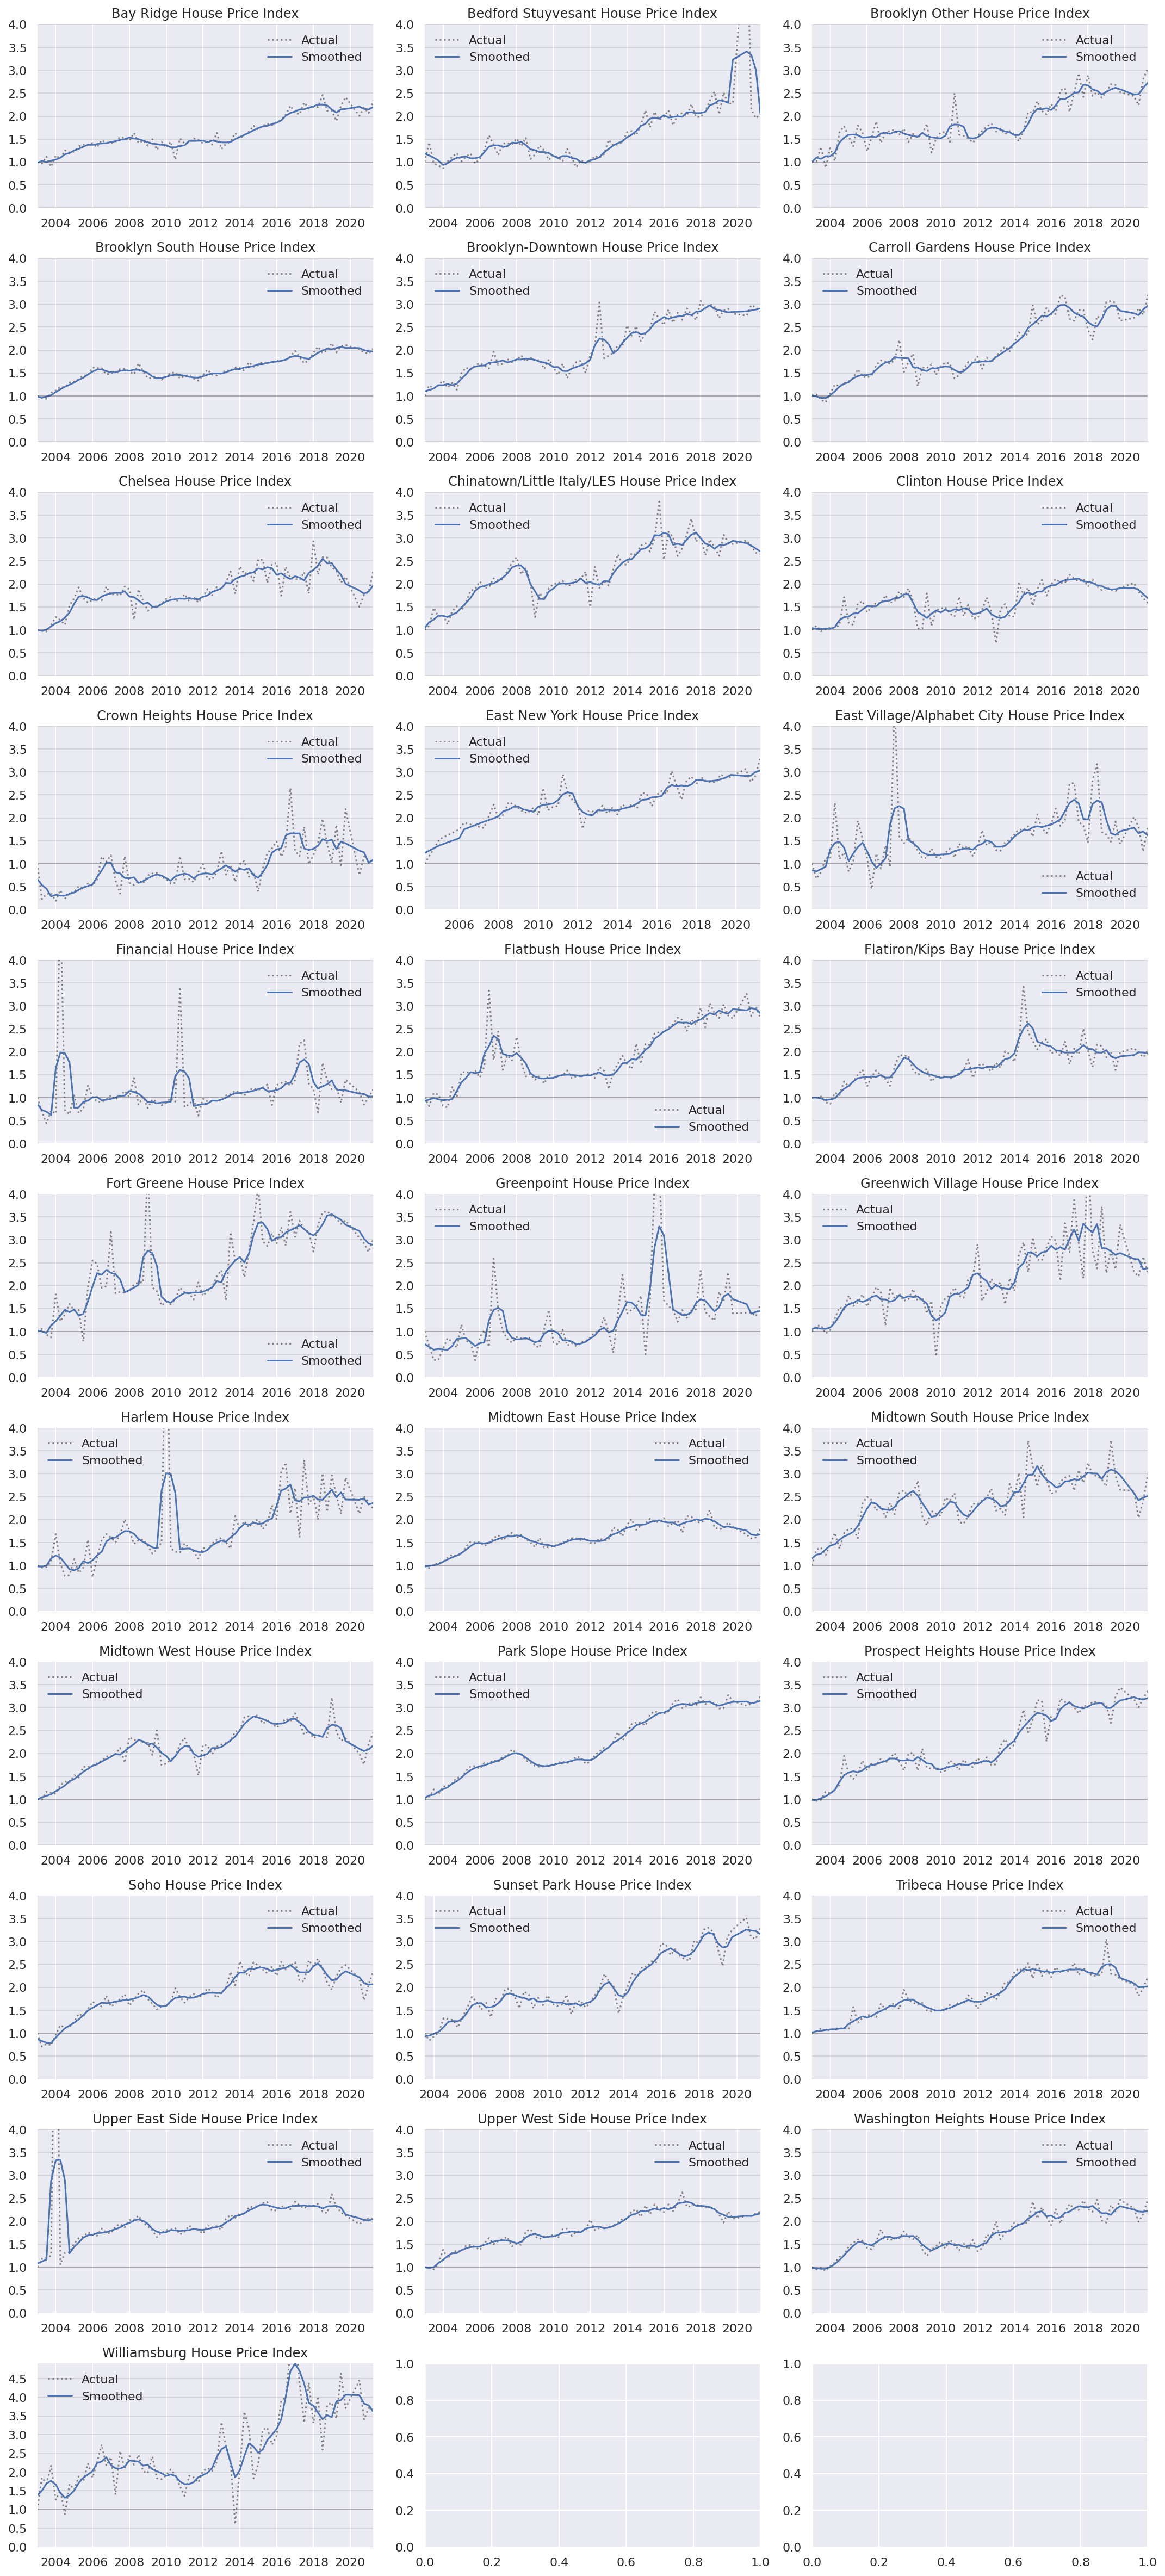

In [25]:
ncols = 3
nrows = int(np.ceil(len(neighborhood_idx.groupby('neighborhood').groups) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3), sharey=False)

for row, (name, idx) in enumerate(neighborhood_idx.groupby('neighborhood')):
    ylim = (0, max(4.0, idx.smoothed.max()))
    plot_idx(idx, axes.flat[row], name, ylim=ylim)
                                  
fig.tight_layout()

Calculate the year over year price change for each neighborhood, sort values, and plot:

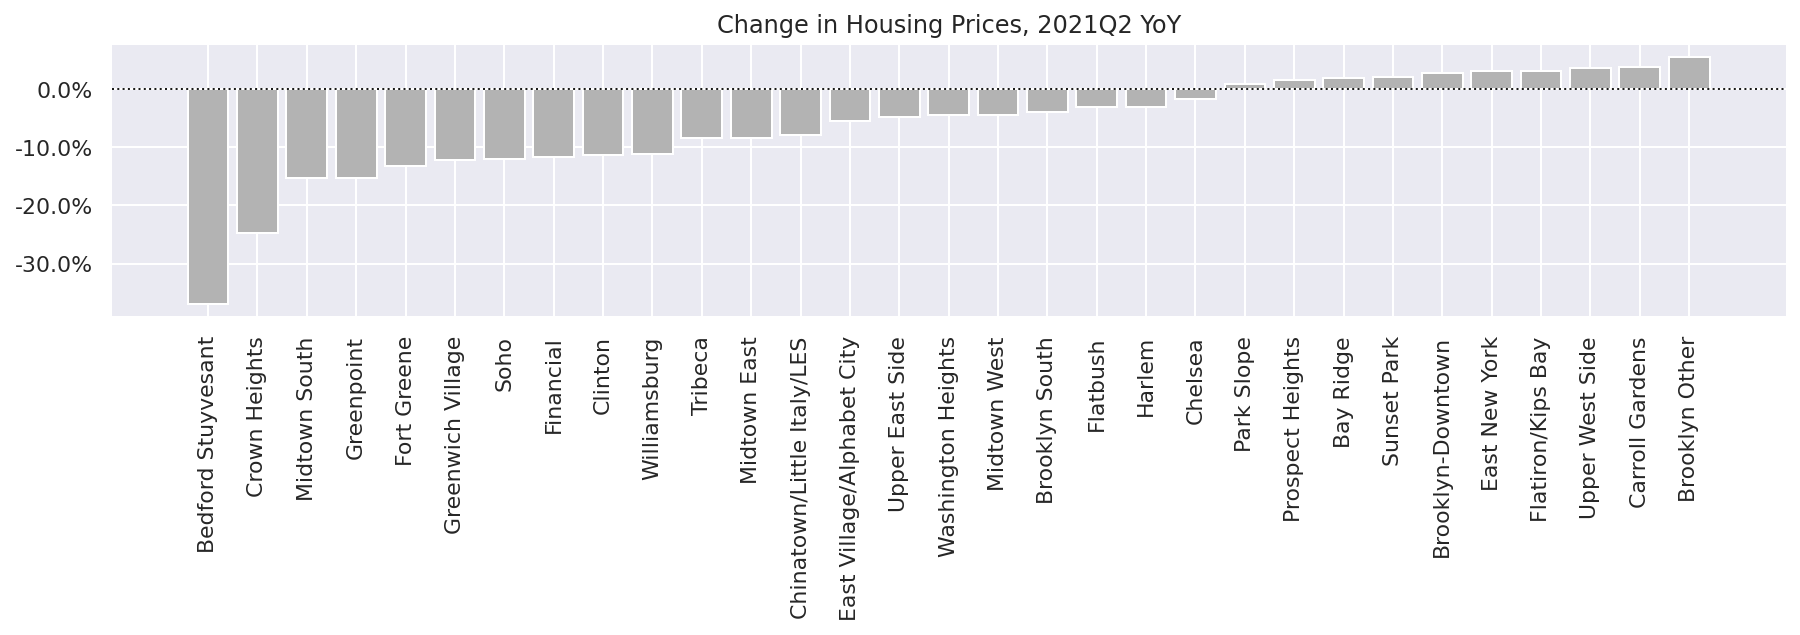

In [26]:
mr = neighborhood_idx.set_index('neighborhood',append=True).smoothed.unstack('neighborhood').pct_change(4).iloc[qtr_offset]
mr.sort_values(inplace=True)
plot_standings(mr, title=f"Change in Housing Prices, {neighborhood_idx.index[qtr_offset]} YoY")

Print the percent change in house values as well for reference:

In [27]:
mr.map('{:,.0%}'.format)

neighborhood
Bedford Stuyvesant            -37%
Crown Heights                 -25%
Midtown South                 -15%
Greenpoint                    -15%
Fort Greene                   -13%
Greenwich Village             -12%
Soho                          -12%
Financial                     -12%
Clinton                       -11%
Williamsburg                  -11%
Tribeca                        -8%
Midtown East                   -8%
Chinatown/Little Italy/LES     -8%
East Village/Alphabet City     -5%
Upper East Side                -5%
Washington Heights             -4%
Midtown West                   -4%
Brooklyn South                 -4%
Flatbush                       -3%
Harlem                         -3%
Chelsea                        -2%
Park Slope                      1%
Prospect Heights                2%
Bay Ridge                       2%
Sunset Park                     2%
Brooklyn-Downtown               3%
East New York                   3%
Flatiron/Kips Bay               3%
Upper W

Show the Quarter over Quarter change:

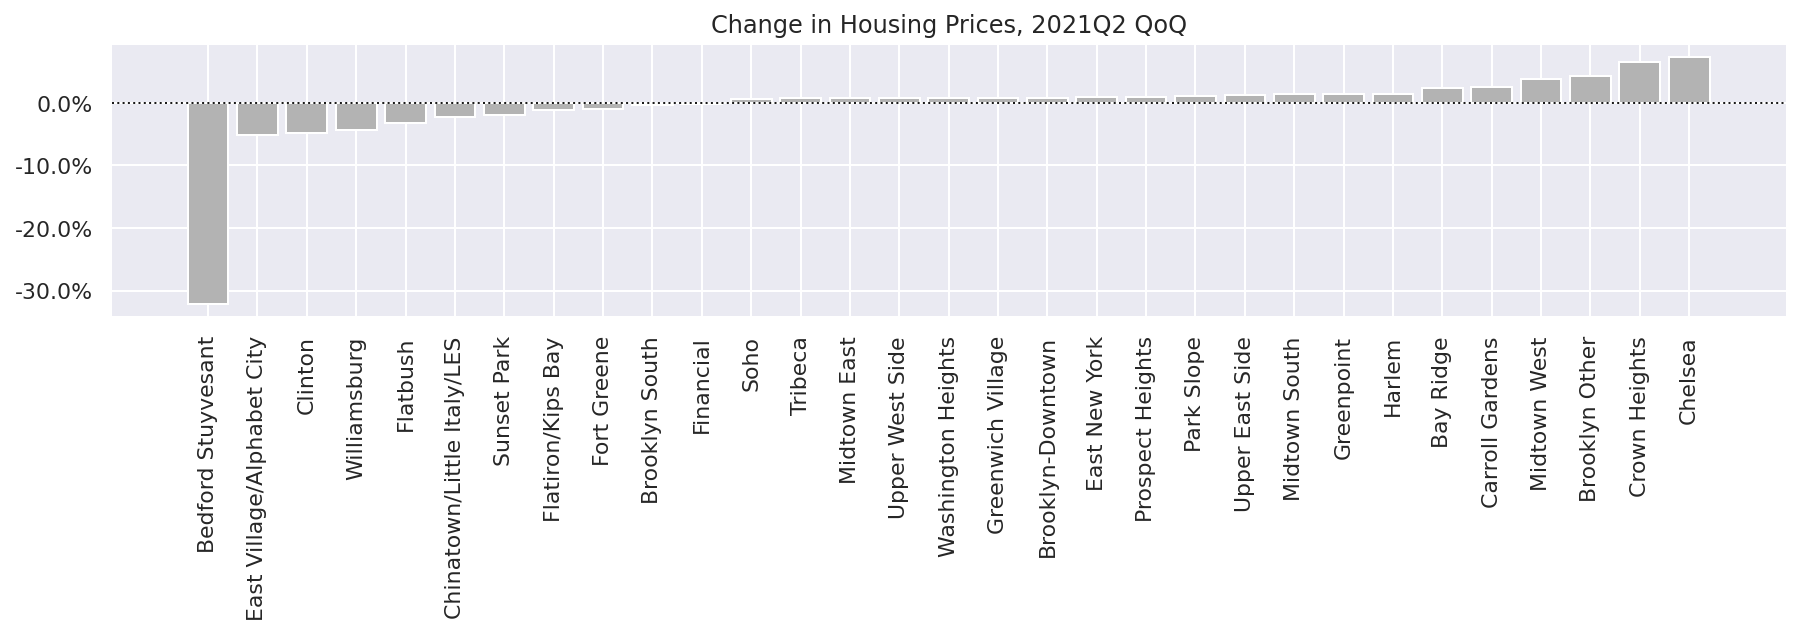

In [28]:
mr = neighborhood_idx.set_index('neighborhood',append=True).smoothed.unstack('neighborhood').pct_change().iloc[qtr_offset]
mr.sort_values(inplace=True)
plot_standings(mr, title=f"Change in Housing Prices, {neighborhood_idx.index[qtr_offset]} QoQ")

In [29]:
mr.map('{:,.0%}'.format)

neighborhood
Bedford Stuyvesant            -32%
East Village/Alphabet City     -5%
Clinton                        -5%
Williamsburg                   -4%
Flatbush                       -3%
Chinatown/Little Italy/LES     -2%
Sunset Park                    -2%
Flatiron/Kips Bay              -1%
Fort Greene                    -1%
Brooklyn South                 -0%
Financial                      -0%
Soho                            1%
Tribeca                         1%
Midtown East                    1%
Upper West Side                 1%
Washington Heights              1%
Greenwich Village               1%
Brooklyn-Downtown               1%
East New York                   1%
Prospect Heights                1%
Park Slope                      1%
Upper East Side                 1%
Midtown South                   1%
Greenpoint                      1%
Harlem                          1%
Bay Ridge                       2%
Carroll Gardens                 3%
Midtown West                    4%
Brookly